In [ ]:

# ==========================================
# Cell 1: Setup and Installation
# ==========================================

!pip install tensorflow scikit-learn pandas numpy -q

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dense, LSTM, Bidirectional, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print(f" TensorFlow version: {tf.__version__}")

 TensorFlow version: 2.18.0


In [ ]:

# ==========================================
# Cell 2: Mount Drive and Setup Paths
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Project configuration
PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'
DATA_DIR = f'{PROJECT_ROOT}/data'
MODELS_DIR = f'{PROJECT_ROOT}/models'
RESULTS_DIR = f'{PROJECT_ROOT}/results'
OUTPUTS_DIR = f'{PROJECT_ROOT}/outputs'

# Ensure output directories exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/protein_classification


In [ ]:
# ==========================================
# Cell 3: Model Configuration and Hyperparameters
# ==========================================

MODEL_NAME = 'CustomLSTM'


lstm_config = {
    'max_length': 1024,
    'embed_dim': 64,
    'lstm_units': 32,
    'learning_rate': 1e-4,
    'batch_size': 128,
    'epochs': 15,
    'dropout_rate_lstm': 0.3,
    'dropout_rate_dense': 0.4,
    'early_stopping_patience': 5,
    'reduce_lr_patience': 2,
}

print("LSTM Model Configuration:")
for key, value in lstm_config.items():
    print(f"  {key}: {value}")

LSTM Model Configuration:
  max_length: 1024
  embed_dim: 64
  lstm_units: 32
  learning_rate: 0.0001
  batch_size: 128
  epochs: 15
  dropout_rate_lstm: 0.3
  dropout_rate_dense: 0.4
  early_stopping_patience: 5
  reduce_lr_patience: 2


In [ ]:
# ==========================================
# Cell 4: Load Data Splits
# ==========================================

def load_data_splits():
    """Load the prepared data splits"""
    splits_path = f'{RESULTS_DIR}/data_splits.pkl'

    if not os.path.exists(splits_path):
        print("Data splits not found!")
        print("Please run 01_data_preparation.ipynb first.")
        return None

    try:
        with open(splits_path, 'rb') as f:
            data_splits = pickle.load(f)
        print("Data splits loaded successfully!")

        for split_name, split_data in data_splits.items():
            if isinstance(split_data, list):
                print(f"  {split_name}: {len(split_data):,} samples")

        return data_splits
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

data_splits = load_data_splits()

Data splits loaded successfully!
  train_seq: 48,000 samples
  train_labels: 48,000 samples
  val_seq: 16,000 samples
  val_labels: 16,000 samples
  test_seq: 16,000 samples
  test_labels: 16,000 samples


In [ ]:
# ==========================================
# Cell 5: Data Preparation Functions
# ==========================================

def prepare_sequences_for_keras(sequences, max_length):
    """Prepare protein sequences for Keras models"""

    char_vals = {
        "M":1, "N":2, "S":3, "K":4, "I":5, "F":6, "A":7, "V":8, "L":9, "G":10,
        "R":11, "C":12, "D":13, "Q":14, "Y":15, "P":16, "T":17, "E":18,
        "H":19, "W":20, "X":21, "U":22, "Z":23, "B":24, "O":25, "-":26
    }
    max_tokens_count = len(char_vals) + 1


    def encode_sequence(sequence):
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + "-" * (max_length - len(sequence))

        return [char_vals.get(char, 26) for char in sequence]

    print(f"Encoding {len(sequences):,} sequences with max_length={max_length}...")
    encoded = np.array([encode_sequence(seq) for seq in sequences])
    print(f"Encoded shape: {encoded.shape}")

    return encoded, max_tokens_count

# Prepare data for training
if data_splits is not None:
    print("Preparing data for LSTM...")

    X_train, max_tokens_train = prepare_sequences_for_keras(data_splits['train_seq'], lstm_config['max_length'])
    X_val, max_tokens_val = prepare_sequences_for_keras(data_splits['val_seq'], lstm_config['max_length'])
    X_test, max_tokens_test = prepare_sequences_for_keras(data_splits['test_seq'], lstm_config['max_length'])

    MAX_TOKENS = max(max_tokens_train, max_tokens_val, max_tokens_test)

    y_train = np.array(data_splits['train_labels'])
    y_val = np.array(data_splits['val_labels'])
    y_test = np.array(data_splits['test_labels'])

    print(f"Data preparation complete!")
    print(f"  Training: {X_train.shape} -> {y_train.shape}")
    print(f"  Validation: {X_val.shape} -> {y_val.shape}")
    print(f"  Test: {X_test.shape} -> {y_test.shape}")
    print(f"  Max tokens (vocabulary size): {MAX_TOKENS}")

Preparing data for LSTM...
Encoding 48,000 sequences with max_length=1024...
Encoded shape: (48000, 1024)
Encoding 16,000 sequences with max_length=1024...
Encoded shape: (16000, 1024)
Encoding 16,000 sequences with max_length=1024...
Encoded shape: (16000, 1024)
Data preparation complete!
  Training: (48000, 1024) -> (48000,)
  Validation: (16000, 1024) -> (16000,)
  Test: (16000, 1024) -> (16000,)
  Max tokens (vocabulary size): 27


In [ ]:


def build_lstm_model(input_shape, max_tokens, embed_dim, lstm_units, dropout_rate_lstm, dropout_rate_dense):

    print(f"Building Simplified LSTM model...")
    print(f"  Input shape: {input_shape}")
    print(f"  Max tokens: {max_tokens}")
    print(f"  Embedding dim: {embed_dim}")
    print(f"  LSTM units: {lstm_units}")
    print(f"  LSTM Dropout: {dropout_rate_lstm}")
    print(f"  Dense Dropout: {dropout_rate_dense}")

    # Input layer
    inputs = Input(shape=input_shape, name='sequence_input')

    # Embedding layer
    embed = Embedding(
        input_dim=max_tokens,
        output_dim=embed_dim,
        name='amino_acid_embedding'
    )(inputs)


    x = Bidirectional(
        LSTM(
            units=lstm_units,
            dropout=dropout_rate_lstm,
            recurrent_dropout=dropout_rate_lstm,
            name='lstm_1'
        ),
        name='bidirectional_1'
    )(embed)

    x = Dense(32, activation="relu", name='dense_1')(x)
    x = Dropout(dropout_rate_dense, name='dropout_1')(x)

    outputs = Dense(1, activation="sigmoid", name='classification_output')(x)

    # Create model
    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

# Build the model using configured parameters
model = build_lstm_model(
    input_shape=(lstm_config['max_length'],),
    max_tokens=MAX_TOKENS,
    embed_dim=lstm_config['embed_dim'],
    lstm_units=lstm_config['lstm_units'],
    dropout_rate_lstm=lstm_config['dropout_rate_lstm'],
    dropout_rate_dense=lstm_config['dropout_rate_dense']
)


Building Simplified LSTM model...
  Input shape: (1024,)
  Max tokens: 27
  Embedding dim: 64
  LSTM units: 32
  LSTM Dropout: 0.3
  Dense Dropout: 0.4


In [ ]:

# ==========================================
# Cell 7: Model Compilation and Summary
# ==========================================

try:
    from tensorflow.keras.mixed_precision import Policy
    policy = Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lstm_config['learning_rate']),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(name='precision'), Recall(name='recall')],
    jit_compile=True
)

print("Model Summary:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"Total parameters: {total_params:,}")


Mixed precision enabled
Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Model: "CustomLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ amino_acid_embedding            │ (None, 1024, 64)       │         1,728 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,673 (112.00 KB)

 Trainable params: 28,673 (112.00 KB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 28,673


In [ ]:
# ==========================================
# Cell 8: Setup Training Callbacks
# ==========================================

# Setup callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=lstm_config['early_stopping_patience'],
        restore_best_weights=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=lstm_config['reduce_lr_patience'],
        min_lr=1e-6,
        verbose=1,
        monitor='val_accuracy',
        mode='max'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        f'{MODELS_DIR}/{MODEL_NAME}_best.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max'
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint


In [ ]:


# ==========================================
# Cell 9: Train the Model
# ==========================================

print("Starting LSTM training...")
print("=" * 60)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=lstm_config['epochs'],
    batch_size=lstm_config['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting LSTM training...
Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6157 - loss: 0.6667 - precision: 0.7565 - recall: 0.3414
Epoch 1: val_accuracy improved from -inf to 0.72400, saving model to /content/drive/MyDrive/protein_classification/models/CustomLSTM_best.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 1021s 3s/step - accuracy: 0.6159 - loss: 0.6666 - precision: 0.7565 - recall: 0.3417 - val_accuracy: 0.7240 - val_loss: 0.5443 - val_precision: 0.7527 - val_recall: 0.6672 - learning_rate: 1.0000e-04
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7106 - loss: 0.5542 - precision: 0.7236 - recall: 0.6840
Epoch 2: val_accuracy improved from 0.72400 to 0.73731, saving model to /content/drive/MyDrive/protein_classification/models/CustomLSTM_best.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 1013s 3s/step - accuracy: 0.7106 - loss: 0.5542 - precision: 0.7236 - recall: 0.6841 - val_accuracy: 0.7373 - val_loss: 0.5129 - val_precision: 0.7418 - val_recall: 0.7280 - learnin

In [ ]:
# ==========================================
# Cell 10: Load Best Model and Evaluate
# ==========================================

# Load the best model (saved by ModelCheckpoint)
print("Loading best model for final evaluation...")
try:
    model = tf.keras.models.load_model(f'{MODELS_DIR}/{MODEL_NAME}_best.keras')
except Exception as e:
    print(f"Error loading best model: {e}")
    print("Proceeding with the last trained model (might not be the best).")
    # If loading best model fails, continue with the current model state

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)


# Calculate detailed metrics
print("Calculating detailed metrics...")
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

detailed_results = {
    'eval_accuracy': accuracy_score(y_test, y_pred_binary),
    'eval_precision': precision_score(y_test, y_pred_binary),
    'eval_recall': recall_score(y_test, y_pred_binary),
    'eval_f1': f1_score(y_test, y_pred_binary)
}


Loading best model for final evaluation...
Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 28 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Calculating detailed metrics...


In [ ]:

# ==========================================
# Cell 11: Save Model and Results
# ==========================================

# Save the final model (the best one restored by EarlyStopping)
model_save_path = f'{MODELS_DIR}/{MODEL_NAME}_final.keras'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Print final results
print("=" * 60)
print(f"{MODEL_NAME.upper()} MODEL RESULTS")
print("=" * 60)
print(f"Accuracy:  {detailed_results['eval_accuracy']:.4f}")
print(f"Precision: {detailed_results['eval_precision']:.4f}")
print(f"Recall:    {detailed_results['eval_recall']:.4f}")
print(f"F1-Score:  {detailed_results['eval_f1']:.4f}")
print("=" * 60)

# Prepare results dictionary
results = {
    'model_name': MODEL_NAME,
    'model_checkpoint_path': model_save_path,
    'training_summary': {
        'total_epochs_run': len(history.history['loss']),
        'final_accuracy': detailed_results['eval_accuracy'],
        'final_f1': detailed_results['eval_f1'],
        'target_achieved': detailed_results['eval_accuracy'] >= 0.99
    },
    'stage_results': {
        'final': detailed_results
    },
    'training_history': history.history,
    'model_config': lstm_config,
    'test_data_shape': X_test.shape
}

# Save results
results_path = f'{RESULTS_DIR}/{MODEL_NAME}_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to: {results_path}")

summary_path = f'{RESULTS_DIR}/{MODEL_NAME}_training_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"{MODEL_NAME} Training Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Final Accuracy: {detailed_results['eval_accuracy']:.4f}\n")
    f.write(f"Final F1-Score: {detailed_results['eval_f1']:.4f}\n")
    f.write(f"Target (99%) Achieved: {'Yes' if detailed_results['eval_accuracy'] >= 0.99 else 'No'}\n")

print(f" Summary saved to: {summary_path}")


Model saved to: /content/drive/MyDrive/protein_classification/models/CustomLSTM_final.keras
CUSTOMLSTM MODEL RESULTS
Accuracy:  0.7769
Precision: 0.7452
Recall:    0.8415
F1-Score:  0.7904
Results saved to: /content/drive/MyDrive/protein_classification/results/CustomLSTM_results.pkl
 Summary saved to: /content/drive/MyDrive/protein_classification/results/CustomLSTM_training_summary.txt


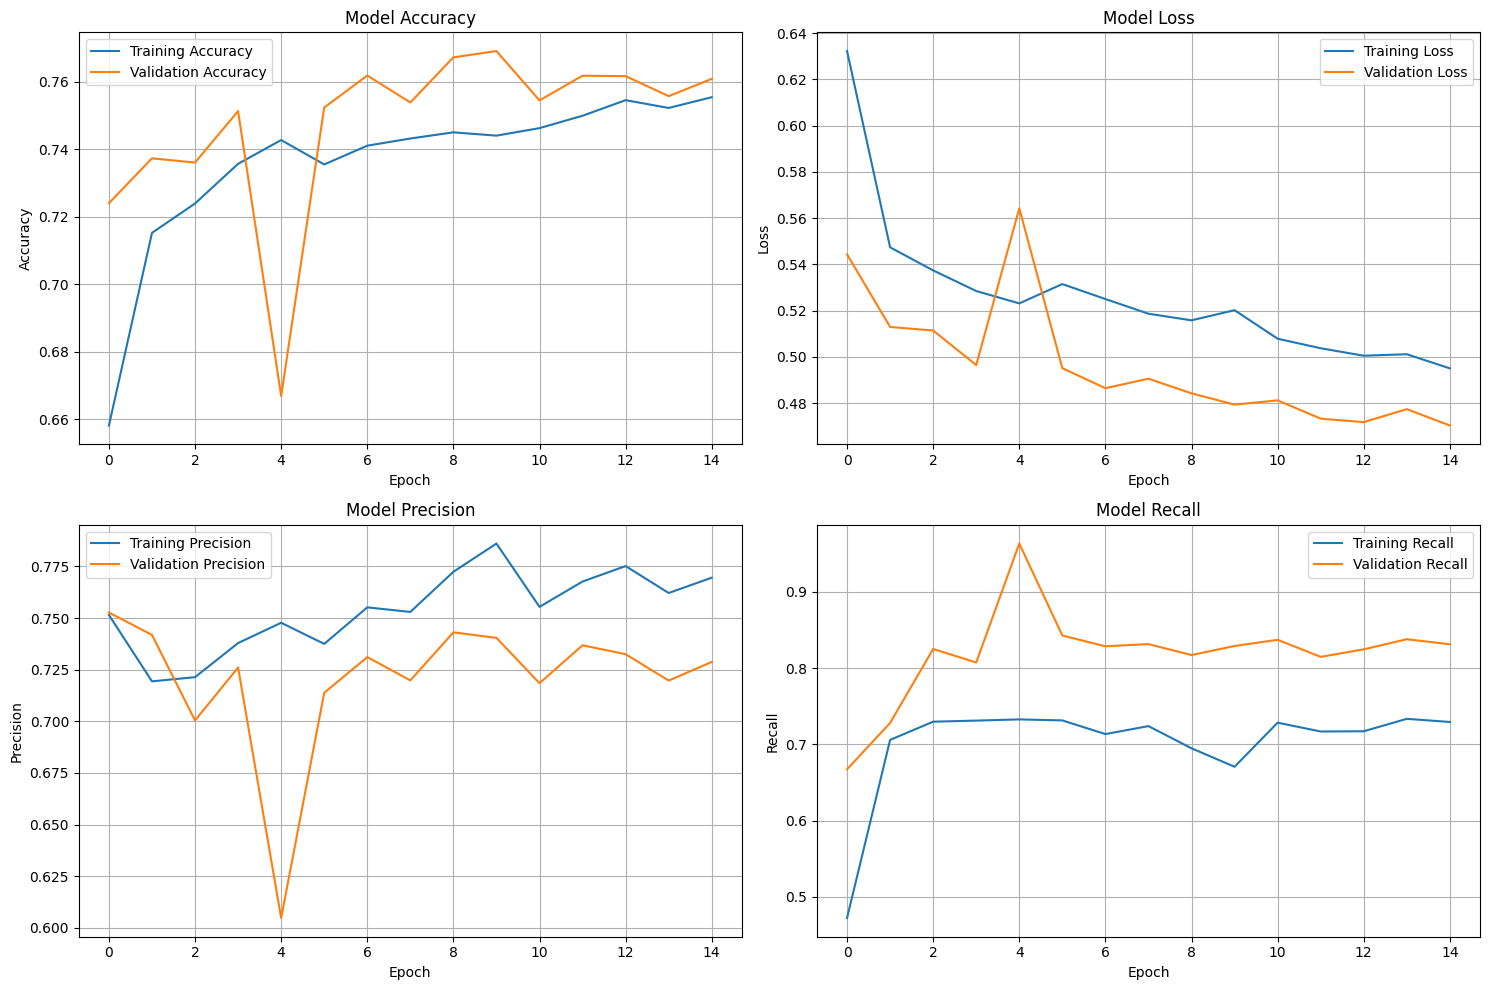

In [ ]:

# ==========================================
# Cell 12: Plot Training History
# ==========================================

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0,0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,0].set_title('Model Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Loss
axes[0,1].plot(history.history['loss'], label='Training Loss')
axes[0,1].plot(history.history['val_loss'], label='Validation Loss')
axes[0,1].set_title('Model Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Precision
axes[1,0].plot(history.history['precision'], label='Training Precision')
axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
axes[1,0].set_title('Model Precision')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()
axes[1,0].grid(True)

# Recall
axes[1,1].plot(history.history['recall'], label='Training Recall')
axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
axes[1,1].set_title('Model Recall')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Recall')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/{MODEL_NAME}_training_history.png', dpi=300, bbox_inches='tight') # 统一命名
plt.show()